# Example usage of data-drive-quadtrature annealing optimization

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datadrivenquadrature import *

In [2]:
# Load in data
x_file_path = './../data/pyarts_training_72000_all_levels.h5'
x = xr.open_mfdataset(x_file_path, combine = 'nested', concat_dim = 'column', engine = "netcdf4")
x_sup = np.reshape(np.array(x['spectral_fluxes']), (55*50, x['spectral_fluxes'].shape[-1]))
# y_file_path = './../data/spec_outgoing_net_norm_4angle.h5'
# y_ref = xr.open_dataset(y_file_path, engine = "netcdf4")
y_ref = np.array(x['reference_fluxes'].data).flatten()

In [3]:
print("x:\n", x)
print("y:\n", np.asarray(y_ref).shape)
print("x_sup:\n", x_sup.shape)
print("axis_len:\n", (x['spectral_fluxes'].shape)[-1])

x:
 <xarray.Dataset>
Dimensions:            (half_level: 55, column: 50, spectral_coord: 72120,
                        level: 54)
Coordinates:
  * half_level         (half_level) int64 0 1 2 3 4 5 6 ... 48 49 50 51 52 53 54
  * level              (level) int64 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * column             (column) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * spectral_coord     (spectral_coord) float32 0.0002 0.0202 ... 3.26e+03
Data variables:
    spectral_fluxes    (half_level, column, spectral_coord) float64 dask.array<chunksize=(55, 50, 72120), meta=np.ndarray>
    reference_fluxes   (half_level, column) float64 dask.array<chunksize=(55, 50), meta=np.ndarray>
    reference_heating  (column, level) float64 dask.array<chunksize=(50, 54), meta=np.ndarray>
    pressures          (column, half_level) float32 dask.array<chunksize=(50, 55), meta=np.ndarray>
y:
 (2750,)
x_sup:
 (2750, 72120)
axis_len:
 72120


In [4]:
norm_vector = find_normalization_vector(x, ['spectral_coord'])
print(norm_vector)

def user_cost_fnc(y, y_hat):
    cost = cp.norm2(y - y_hat)
    # cost = cp.norm(y - y_hat)
    # cost = sum(y, y_hat)
    return sum(cost)

def map_func(x, point_set, x_sup=None):
    point_idxs = [point[0] for point in point_set]
    points = np.array(x.spectral_fluxes[:,:,point_idxs].values).reshape((55*50, 15)) / norm_vector[0][0]
    return points

[(3259.5046, 0.0002)]


In [7]:
params = {}
integration_list = ['spectral_coord']
params['integration_list'] = integration_list
params['n_points'] = 15
params['epochs'] = 2
params['success'] = 5
params['block_size'] = 10
check_params(x,  y_ref / norm_vector[0][0], user_cost_fnc, map_func, params, x_sup=x_sup)

<class 'int'>


0

In [8]:
history = optimize(x, y_ref / norm_vector[0][0], user_cost_fnc, map_func, params, x_sup=x_sup)

<class 'int'>
INITIAL BLOCK: iteration 0
INITIAL BLOCK: iteration 1
INITIAL BLOCK: iteration 2
INITIAL BLOCK: iteration 3
INITIAL BLOCK: iteration 4
INITIAL BLOCK: iteration 5
INITIAL BLOCK: iteration 6
INITIAL BLOCK: iteration 7
INITIAL BLOCK: iteration 8
INITIAL BLOCK: iteration 9
1 0 [[16916], [67253], [3865], [20872], [9772], [64563], [8793], [21498], [64887], [61223], [43749], [4812], [63042], [58169], [51628]] 0.0
1 1 [[16916], [67253], [15893], [20872], [9772], [64563], [8793], [21498], [64887], [61223], [43749], [4812], [63042], [58169], [51628]] 0.0
1 2 [[16916], [67253], [15893], [14586], [9772], [64563], [8793], [21498], [64887], [61223], [43749], [4812], [63042], [58169], [51628]] 0.0
1 3 [[16916], [67253], [15893], [14586], [9772], [64563], [8793], [21498], [64887], [61223], [43749], [4812], [63042], [58169], [33939]] 0.0
1 4 [[16916], [67253], [15893], [14586], [9772], [64563], [48308], [21498], [64887], [61223], [43749], [4812], [63042], [58169], [33939]] 0.0


dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(1, 4)


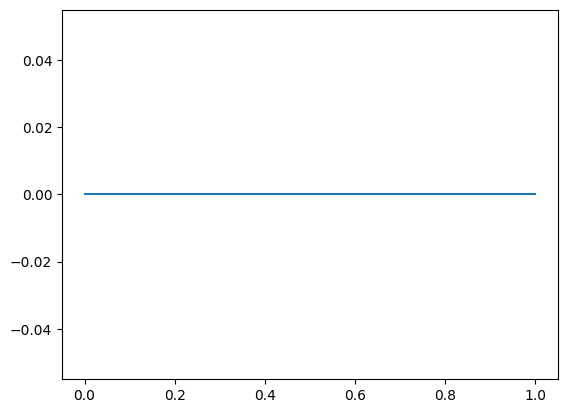

In [9]:
# Plot cost history
mean_costs = []
for cost in history['cost']:
    mean_costs.append(np.min(cost))

plt.plot(np.arange(len(mean_costs)), mean_costs)
print(history.keys())
print(history['best'])
# print(sum(history['weight_sets'][5][4]))
# print(history['cost'][6][4])


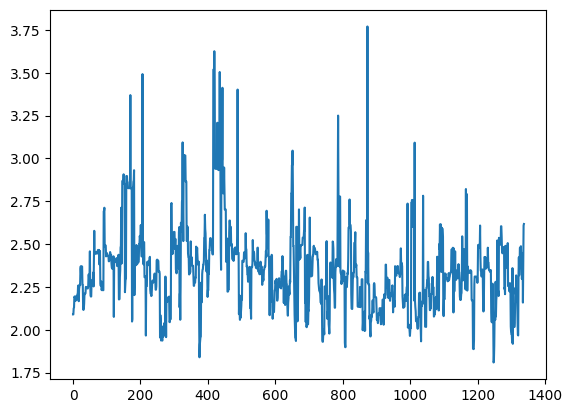

In [21]:
flat_history = flatten_history(history)
flat_cost = flat_history['cost']
plt.plot(range(len(flat_cost)), np.log10(flat_cost))